In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.vgg19 import VGG19,preprocess_input
import os
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-artworks-of-all-time/artists.csv
/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_132.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Albrecht_Dürer_59.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Andrei_Rublev_21.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_586.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_9.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_559.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Amedeo_Modigliani_169.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_804.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Amedeo_Modigliani_71.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Frida_Kahlo_68.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Albrecht_Dürer_307.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Andy_Warhol_3

In [2]:
artists=os.listdir('../input/best-artworks-of-all-time/images/images')

In [3]:
size=360

In [4]:
model=VGG19(include_top=False,input_shape=(size,size,3))
model.trainable=False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 360, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 360, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 180, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 180, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 180, 128)     147584    
______________________________________________________________

In [5]:
content_layer='block3_conv4'
content_model=Model(inputs=model.input,outputs=model.get_layer(content_layer).output)

In [6]:
style_layers=[ 'block1_conv1', 'block2_conv2','block3_conv3', 'block4_conv4','block5_conv2']
style_models=[Model(inputs=model.input,outputs=model.get_layer(style_layer).output) for style_layer in style_layers]

In [7]:
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G 
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost =  tf.reduce_mean(tf.square(generated_img-content_img))
    return cost
def style_cost(style_img, generated_img):
    total_cost = 0
    
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS-GG))
        total_cost += current_cost
    return total_cost

In [8]:
content_image_path='../input/best-artworks-of-all-time/images/images/Leonardo_da_Vinci/Leonardo_da_Vinci_121.jpg'
style_image_path='../input/best-artworks-of-all-time/images/images/Francisco_Goya/Francisco_Goya_100.jpg'


In [9]:
def read_img(path):
    img=tf.keras.preprocessing.image.load_img(path,target_size=(size,size))
    img=tf.keras.preprocessing.image.img_to_array(img,dtype='uint8')
    img=np.expand_dims(img,axis=0)
    return img


In [10]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [11]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        image = image[0,:,:,:]

    img = deprocess(image)
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

In [12]:
lr = 23
size = 360
iterations = 250
style_wt = 0.008
content_wt = 0.8
style_layer_wts = [4,2,1,0.1,0.1]

In [13]:
def generate(content_image_path,style_image_path):
    content_image_preprocessed = preprocess_image(content_image_path)
    style_image_preprocessed = preprocess_image(style_image_path)
    generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

    generated_images = []
    costs = []

    min_cost=1*10**12
    optimizer = tf.optimizers.Adam(learning_rate=lr)

    for i in range(iterations):
    
        with tf.GradientTape() as tape:
            J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
            J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)
            J_total = content_wt * J_content + style_wt * J_style
    
        gradients = tape.gradient(J_total, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])
    
        costs.append(J_total.numpy())
        generated_images.append(generated_image.numpy())
        min_cost=J_total
        if i%50==0:
            print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))
    return generated_images

In [14]:
generated_images=generate(content_image_path,style_image_path)

Iteration:1/250, Total Cost:2.929478222007501e+16, Style Cost: 3.6618476100056515e+18, Content Cost: 0.0
Iteration:51/250, Total Cost:1272007446495232.0, Style Cost: 1.5900092624850125e+17, Content Cost: 4481.40283203125
Iteration:101/250, Total Cost:292724368474112.0, Style Cost: 3.65905443815424e+16, Content Cost: 6961.06201171875
Iteration:151/250, Total Cost:53155106652160.0, Style Cost: 6644387958226944.0, Content Cost: 8597.677734375
Iteration:201/250, Total Cost:24328208908288.0, Style Cost: 3041026092564480.0, Content Cost: 8947.6982421875


In [15]:
generated_image=Image.fromarray(deprocess(generated_images[-1][0]))

<function matplotlib.pyplot.show(*args, **kw)>

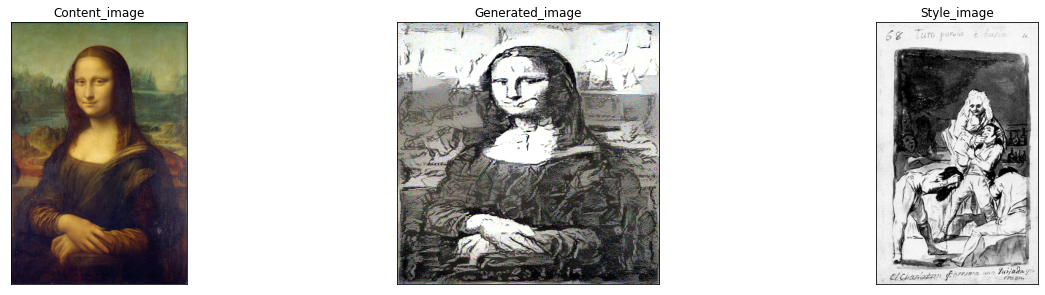

In [16]:
plt.figure(figsize=(24,8))
dict_title={1:"Content_image",2:"Generated_image",3:"Style_image"}
images={1:tf.keras.preprocessing.image.load_img(content_image_path),2:generated_image,3:tf.keras.preprocessing.image.load_img(style_image_path)}
for i in range(1,4):
    plt.subplot(2,4,i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(dict_title[i])
plt.savefig('out2.png')
plt.show